In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [4]:
def convert_to_displayable_image(image):
    # Convert from tensor to NumPy if needed
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # If image is float32, scale to [0, 255] and convert to uint8
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    # If image is in channels-first format, convert to channels-last
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)  # Convert CxHxW to HxWxC

    return Image.fromarray(image)

In [5]:
# def calculate_flann_distances(flann, query_embeddings, train_embeddings, top_matches):
#     distances = []
#     for query_emb, top_indices in zip(query_embeddings, top_matches):
#         query_distances = [cv2.norm(query_emb, train_embeddings[idx], cv2.NORM_L2) for idx in top_indices]
#         distances.append(query_distances)
#     return distances

#### Method to extract patches from image based on keypoints

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
import numpy as np

def show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to displayable format
    image1_np = image1
    image2_np = image2

    # Display original images
    axs[0].imshow(image1_np)
    axs[1].imshow(image2_np)

    # Overlay patches on images
    for kpt1, kpt2 in zip(good_kpts1, good_kpts2):
        x1, y1 = kpt1.pt
        x2, y2 = kpt2.pt
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data',
                               axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    for kpt1, kpt2 in zip(bad_kpts1, bad_kpts2):
        x1, y1 = kpt1.pt
        x2, y2 = kpt2.pt
        color = 'red'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data',
                               axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    plt.grid(False)
    plt.savefig("sift_slice_match.png")
    plt.show()


In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# def apply_ratio_test(matches, ratio_threshold=0.75):
#     good_matches = []
#     for m, n in matches:
#         if m[1] > ratio_threshold * n[1]:  # Notice the ">" because we're dealing with similarity (not distance)
#             good_matches.append(m[0])
#     return good_matches

def match_keypoints(desc1, desc2, ratio_threshold=0.75, sim_threshold=0.5):
    # Calculate the cosine similarity between descriptors
    cos_sim = cosine_similarity(desc1, desc2)
    
    # For each descriptor in the first image, find the two best matches in the second image
    matches = []
    for i, similarities in enumerate(cos_sim):
        sorted_indices = np.argsort(similarities)[::-1]  # "-" for descending order
        best_matches = (i, sorted_indices[0], similarities[sorted_indices[0]])
                        # (i, sorted_indices[1], similarities[sorted_indices[1]])]
        matches.append(best_matches)

    # print(matches)
    
    # Apply the ratio test
    # good_matches_idx = apply_ratio_test(matches, ratio_threshold)
    
    # Optionally, filter by similarity threshold
    final_matches = [(i, j) for i, j, sim in matches if sim >= sim_threshold]
    
    return final_matches

In [42]:
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    kernel_size = 11  # This corresponds to reducing the ROI by 5 pixels in each direction
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to reduce the ROI
    eroded_mask = cv2.erode(binary_mask.cpu().numpy(), kernel, iterations=1)

    # Apply the mask
    masked_image = image * torch.from_numpy(eroded_mask).unsqueeze(0).to(device)

    return masked_image, binary_mask

In [43]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [44]:
from sklearn.cluster import DBSCAN
import numpy as np

def cluster_keypoints_dbscan(kpts2, eps=2, min_samples=2):
    """
    Cluster keypoints in image 2 using DBSCAN.

    Parameters:
    - kpts2: numpy array of keypoints in image 2 of shape (N2, 2).
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
    - clustered_kpts: numpy array of the centroid of each cluster.
    """

    # Run DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(kpts2)
    
    clustered_kpts = []
    for label in set(clustering.labels_):
        if label == -1:
            # Skip noise points
            continue
        # Find the centroid of each cluster
        cluster_points = kpts2[clustering.labels_ == label]
        centroid = cluster_points.mean(axis=0)
        clustered_kpts.append(centroid)

    return np.array(clustered_kpts)

# Assuming kpts2 is a numpy array containing the keypoints from image 2
# Example usage:
# clustered_kpts2 = cluster_keypoints_dbscan(kpts2.numpy(), eps=5, min_samples=3)

In [45]:
def filter_one_to_one_matches(matches):
    # Sort matches based on score so that higher scores come first
    matches.sort(key=lambda x: x[2], reverse=True)
    
    match_index1 = set()
    match_index2 = set()
    filtered_matches = []
    
    for index1, index2, score in matches:
        # If neither index1 nor index2 have been used yet, add the match
        if index1 not in match_index1 and index2 not in match_index2:
            filtered_matches.append((index1, index2, score))
            match_index1.add(index1)
            match_index2.add(index2)
    
    return filtered_matches

/tmp/ipykernel_13958/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 137
TPs: 10
FPs: 127
TPR: 7.2992700729927%
FPR: 92.7007299270073%


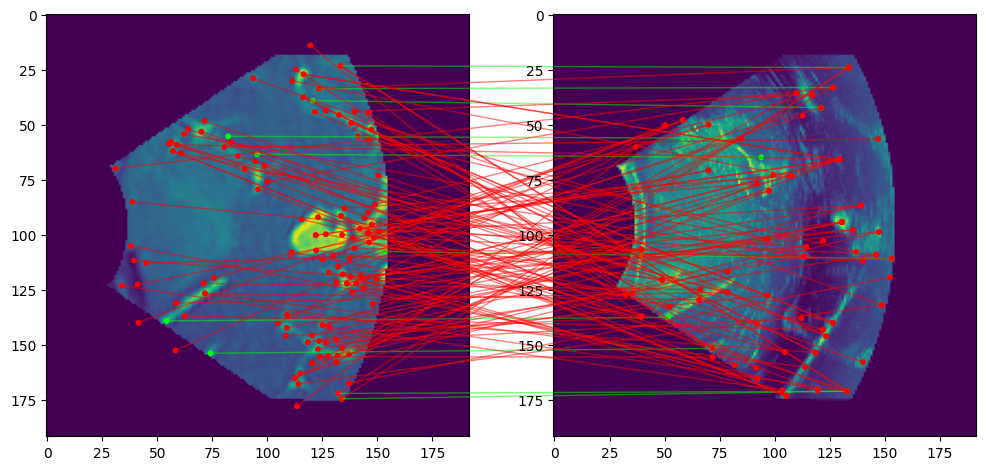

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

device = "cuda:0"

# Function to get embeddings for a list of patches
def get_embeddings(patches):
    embeddings = []
    # print(patches)
    for patch in patches:
        patch_processed = preprocess_image(patch).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            embedding = model.get_embedding(patch_processed)
        embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)


def extract_and_match_patches(image1, image2, device, patch_size=64):
    #Not used anymore, doesn't affect results if ratio test is used
    sim_threshold = 0.5
    
    # Preprocess and extract patches from both images
    # image1 = image1.to(device)
    # image2 = image2.to(device)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and descriptors with SIFT
    kpts1, desc1 = sift.detectAndCompute(image1, None)
    kpts2, desc2 = sift.detectAndCompute(image2, None)
    
    # Assuming desc1 and desc2 are the descriptors for image1 and image2 obtained from SIFT
    final_matches = match_keypoints(desc1, desc2, sim_threshold=0.5)

    # Filter the keypoints based on the final matches
    filtered_kpts1 = [kpts1[i] for i, _ in final_matches]
    filtered_kpts2 = [kpts2[j] for _, j in final_matches]

    all_matches = len(filtered_kpts1)
    print(f"All Matches: {all_matches}")

    # patches1, filtered_good_kpts1 = extract_patches(image1.cpu().numpy(), filtered_good_kpts1, size=patch_size)
    # patches2, filtered_good_kpts2 = extract_patches(image2.cpu().numpy(), filtered_good_kpts2, size=patch_size)
    
    # print(f"All Matches (within threshold): {len(filtered_top_matches)}")
    good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2, similar_patches_count = extract_good_and_bad_matches(filtered_kpts1, filtered_kpts2)
    print(f"TPs: {len(good_good_kpts1)}")
    print(f"FPs: {len(bad_good_kpts1)}")
    print(f"TPR: {len(good_good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_good_kpts1)/all_matches*100}%")
    # print(f"Percentage of Good Matches: {(len(good_good_kpts1)/len(good_kpts1))*100}%")
    show_matched_keypoints(image1, image2, good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2)
    return kpts1, kpts2, good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2

def extract_good_and_bad_matches(good_kpts1, good_kpts2, margin=4):
    # Extract coordinates from cv2.KeyPoint objects
    good_kpts1_coords = np.array([kp.pt for kp in good_kpts1])
    good_kpts2_coords = np.array([kp.pt for kp in good_kpts2])

    # Now you can compute the differences between keypoints
    diff = np.abs(good_kpts1_coords - good_kpts2_coords)

    # Identify good matches based on the margin
    good_matches_mask = np.all(diff <= margin, axis=1)

    # Filter keypoints based on the good matches mask
    good_good_kpts1 = [good_kpts1[i] for i in range(len(good_kpts1)) if good_matches_mask[i]]
    good_good_kpts2 = [good_kpts2[i] for i in range(len(good_kpts2)) if good_matches_mask[i]]
    # good_good_distances = good_distances[good_matches_mask]

    bad_good_kpts1 = [good_kpts1[i] for i in range(len(good_kpts1)) if not good_matches_mask[i]]
    bad_good_kpts2 = [good_kpts2[i] for i in range(len(good_kpts2)) if not good_matches_mask[i]]
    # bad_good_distances = good_distances[~good_matches_mask]

    count = np.sum(good_matches_mask)

    return good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2, count



def convert_image_for_opencv(image_tensor):
    # Convert from PyTorch tensor to NumPy array
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
    # Convert from float [0,1] to uint8 [0,255]
    image_np = (image_np * 255).astype(np.uint8)
    # Convert to grayscale
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    return image_gray

def preprocess_image(image):
    # Implement any preprocessing steps (resizing, normalization, etc.)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to PyTorch tensor in CxHxW format
        transforms.Normalize(mean=(0), std=(1))  # Normalize the image
    ])
    image = transform(image).to(device)
    return image

long_side = 192

image1 = load_path_for_pytorch("data/mr_us/Case096/t2/035.png", long_side,force_scale=True).to(device)
image2 = load_path_for_pytorch("data/mr_us/Case096/us/035.png", long_side,force_scale=True).to(device)

# Convert images for OpenCV
image1_gray = convert_image_for_opencv(image1)
image2_gray = convert_image_for_opencv(image2)

kpts1, kpts2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2 = extract_and_match_patches(image1_gray, image2_gray, device)

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2


def extract_and_match_patches_all(image1, image2, device, patch_size=64):
    #Not used anymore, doesn't affect results if ratio test is used
    sim_threshold = 0.5
    
    # Preprocess and extract patches from both images
    # image1 = image1.to(device)
    # image2 = image2.to(device)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and descriptors with SIFT
    kpts1, desc1 = sift.detectAndCompute(image1, None)
    kpts2, desc2 = sift.detectAndCompute(image2, None)
    
    # Assuming desc1 and desc2 are the descriptors for image1 and image2 obtained from SIFT
    final_matches = match_keypoints(desc1, desc2, sim_threshold=sim_threshold)

    # Filter the keypoints based on the final matches
    filtered_kpts1 = [kpts1[i] for i, _ in final_matches]
    filtered_kpts2 = [kpts2[j] for _, j in final_matches]

    all_matches = len(filtered_kpts1)
    print(f"All Matches: {all_matches}")

    # patches1, filtered_good_kpts1 = extract_patches(image1.cpu().numpy(), filtered_good_kpts1, size=patch_size)
    # patches2, filtered_good_kpts2 = extract_patches(image2.cpu().numpy(), filtered_good_kpts2, size=patch_size)
    
    # print(f"All Matches (within threshold): {len(filtered_top_matches)}")
    good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2, similar_patches_count = extract_good_and_bad_matches(filtered_kpts1, filtered_kpts2)
    print(f"TPs: {len(good_good_kpts1)}")
    print(f"FPs: {len(bad_good_kpts1)}")
    print(f"TPR: {len(good_good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_good_kpts1)/all_matches*100}%")
    return all_matches, len(good_good_kpts1), len(bad_good_kpts1), len(good_good_kpts1)/all_matches*100, len(bad_good_kpts1)/all_matches*100

In [20]:
import numpy as np

# Metrics accumulators
total_matches = 0
total_tps = 0
total_fps = 0
total_tpr = 0
total_fpr = 0
slice_count = 78

for i in range(slice_count):
    slice_num = f"{i:03}.png"  # Format the slice number with leading zeros
    t2_path = f"data/mr_us/Case067/t2/{slice_num}"
    us_path = f"data/mr_us/Case067/us/{slice_num}"
    
    # Load images (modify your load_path_for_pytorch function accordingly)
    image1 = load_path_for_pytorch(t2_path, long_side, force_scale=True).to(device)
    image2 = load_path_for_pytorch(us_path, long_side, force_scale=True).to(device)

    # Convert images for OpenCV
    image1_gray = convert_image_for_opencv(image1)
    image2_gray = convert_image_for_opencv(image2)
    print(f"Slice Number: {i}")
    # Perform matching
    all_matches, tps, fps, tpr, fpr = extract_and_match_patches_all(image1_gray, image2_gray, device)
    
    # Accumulate metrics
    total_matches += all_matches
    total_tps += tps
    total_fps += fps
    total_tpr += tpr
    total_fpr += fpr

# Compute averages
avg_matches = total_matches / slice_count
avg_tps = total_tps / slice_count
avg_fps = total_fps / slice_count
avg_tpr = total_tpr / slice_count
avg_fpr = total_fpr / slice_count

print(f"Average Matches: {avg_matches}")
print(f"Average TPs: {avg_tps}")
print(f"Average FPs: {avg_fps}")
print(f"Average TPR: {avg_tpr}%")
print(f"Average FPR: {avg_fpr}%")


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageI

Slice Number: 0
All Matches: 221
TPs: 9
FPs: 212
TPR: 4.072398190045249%
FPR: 95.92760180995475%
Slice Number: 1
All Matches: 205
TPs: 3
FPs: 202
TPR: 1.4634146341463417%
FPR: 98.53658536585365%
Slice Number: 2
All Matches: 244
TPs: 8
FPs: 236
TPR: 3.278688524590164%
FPR: 96.72131147540983%
Slice Number: 3
All Matches: 262
TPs: 11
FPs: 251
TPR: 4.198473282442748%
FPR: 95.80152671755725%
Slice Number: 4
All Matches: 264
TPs: 10
FPs: 254
TPR: 3.787878787878788%
FPR: 96.21212121212122%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 5
All Matches: 259
TPs: 2
FPs: 257
TPR: 0.7722007722007722%
FPR: 99.22779922779922%
Slice Number: 6
All Matches: 232
TPs: 5
FPs: 227
TPR: 2.1551724137931036%
FPR: 97.84482758620689%
Slice Number: 7


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 257
TPs: 6
FPs: 251
TPR: 2.3346303501945527%
FPR: 97.66536964980544%
Slice Number: 8
All Matches: 233
TPs: 3
FPs: 230
TPR: 1.2875536480686696%
FPR: 98.71244635193133%
Slice Number: 9
All Matches: 245
TPs: 3
FPs: 242
TPR: 1.2244897959183674%
FPR: 98.77551020408163%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 10
All Matches: 223
TPs: 4
FPs: 219
TPR: 1.7937219730941705%
FPR: 98.20627802690582%
Slice Number: 11
All Matches: 205
TPs: 1
FPs: 204
TPR: 0.4878048780487805%
FPR: 99.51219512195122%
Slice Number: 12
All Matches: 200
TPs: 6
FPs: 194
TPR: 3.0%
FPR: 97.0%
Slice Number: 13
All Matches: 211
TPs: 10
FPs: 201
TPR: 4.739336492890995%
FPR: 95.260663507109%
Slice Number: 14
All Matches: 194
TPs: 9
FPs: 185
TPR: 4.639175257731959%
FPR: 95.36082474226805%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 15
All Matches: 206
TPs: 6
FPs: 200
TPR: 2.912621359223301%
FPR: 97.0873786407767%
Slice Number: 16
All Matches: 210
TPs: 6
FPs: 204
TPR: 2.857142857142857%
FPR: 97.14285714285714%
Slice Number: 17


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 200
TPs: 6
FPs: 194
TPR: 3.0%
FPR: 97.0%
Slice Number: 18
All Matches: 201
TPs: 5
FPs: 196
TPR: 2.4875621890547266%
FPR: 97.51243781094527%
Slice Number: 19
All Matches: 213
TPs: 8
FPs: 205
TPR: 3.755868544600939%
FPR: 96.24413145539906%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 20
All Matches: 225
TPs: 4
FPs: 221
TPR: 1.7777777777777777%
FPR: 98.22222222222223%
Slice Number: 21
All Matches: 237
TPs: 4
FPs: 233
TPR: 1.6877637130801686%
FPR: 98.31223628691983%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 22
All Matches: 234
TPs: 4
FPs: 230
TPR: 1.7094017094017095%
FPR: 98.29059829059828%
Slice Number: 23
All Matches: 213
TPs: 7
FPs: 206
TPR: 3.286384976525822%
FPR: 96.71361502347418%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 24
All Matches: 213
TPs: 1
FPs: 212
TPR: 0.4694835680751174%
FPR: 99.53051643192488%
Slice Number: 25
All Matches: 235
TPs: 2
FPs: 233
TPR: 0.851063829787234%
FPR: 99.14893617021276%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 26
All Matches: 241
TPs: 6
FPs: 235
TPR: 2.4896265560165975%
FPR: 97.5103734439834%
Slice Number: 27
All Matches: 258
TPs: 3
FPs: 255
TPR: 1.1627906976744187%
FPR: 98.83720930232558%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 28
All Matches: 244
TPs: 6
FPs: 238
TPR: 2.459016393442623%
FPR: 97.54098360655738%
Slice Number: 29
All Matches: 229
TPs: 2
FPs: 227
TPR: 0.8733624454148471%
FPR: 99.12663755458514%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 30
All Matches: 234
TPs: 4
FPs: 230
TPR: 1.7094017094017095%
FPR: 98.29059829059828%
Slice Number: 31
All Matches: 258
TPs: 5
FPs: 253
TPR: 1.937984496124031%
FPR: 98.06201550387597%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 32
All Matches: 230
TPs: 2
FPs: 228
TPR: 0.8695652173913043%
FPR: 99.1304347826087%
Slice Number: 33
All Matches: 232
TPs: 4
FPs: 228
TPR: 1.7241379310344827%
FPR: 98.27586206896551%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 34
All Matches: 237
TPs: 5
FPs: 232
TPR: 2.109704641350211%
FPR: 97.8902953586498%
Slice Number: 35
All Matches: 216
TPs: 6
FPs: 210
TPR: 2.7777777777777777%
FPR: 97.22222222222221%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 36
All Matches: 225
TPs: 3
FPs: 222
TPR: 1.3333333333333335%
FPR: 98.66666666666667%
Slice Number: 37
All Matches: 228
TPs: 4
FPs: 224
TPR: 1.7543859649122806%
FPR: 98.24561403508771%
Slice Number: 38
All Matches: 228
TPs: 3
FPs: 225
TPR: 1.3157894736842104%
FPR: 98.68421052631578%
Slice Number: 39
All Matches: 195
TPs: 2
FPs: 193
TPR: 1.0256410256410255%
FPR: 98.97435897435898%
Slice Number: 40


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 217
TPs: 2
FPs: 215
TPR: 0.9216589861751152%
FPR: 99.07834101382488%
Slice Number: 41
All Matches: 231
TPs: 5
FPs: 226
TPR: 2.1645021645021645%
FPR: 97.83549783549783%
Slice Number: 42


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 226
TPs: 6
FPs: 220
TPR: 2.6548672566371683%
FPR: 97.34513274336283%
Slice Number: 43
All Matches: 246
TPs: 6
FPs: 240
TPR: 2.4390243902439024%
FPR: 97.5609756097561%
Slice Number: 44


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 247
TPs: 2
FPs: 245
TPR: 0.8097165991902834%
FPR: 99.19028340080972%
Slice Number: 45
All Matches: 232
TPs: 5
FPs: 227
TPR: 2.1551724137931036%
FPR: 97.84482758620689%
Slice Number: 46


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 232
TPs: 4
FPs: 228
TPR: 1.7241379310344827%
FPR: 98.27586206896551%
Slice Number: 47
All Matches: 237
TPs: 4
FPs: 233
TPR: 1.6877637130801686%
FPR: 98.31223628691983%
Slice Number: 48


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 215
TPs: 7
FPs: 208
TPR: 3.255813953488372%
FPR: 96.74418604651163%
Slice Number: 49
All Matches: 226
TPs: 4
FPs: 222
TPR: 1.7699115044247788%
FPR: 98.23008849557522%
Slice Number: 50


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 218
TPs: 3
FPs: 215
TPR: 1.3761467889908259%
FPR: 98.62385321100918%
Slice Number: 51
All Matches: 193
TPs: 9
FPs: 184
TPR: 4.66321243523316%
FPR: 95.33678756476684%
Slice Number: 52


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 195
TPs: 5
FPs: 190
TPR: 2.564102564102564%
FPR: 97.43589743589743%
Slice Number: 53
All Matches: 203
TPs: 2
FPs: 201
TPR: 0.9852216748768473%
FPR: 99.01477832512316%
Slice Number: 54
All Matches: 214
TPs: 7
FPs: 207
TPR: 3.2710280373831773%
FPR: 96.72897196261682%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 55
All Matches: 220
TPs: 7
FPs: 213
TPR: 3.1818181818181817%
FPR: 96.81818181818181%
Slice Number: 56
All Matches: 218
TPs: 6
FPs: 212
TPR: 2.7522935779816518%
FPR: 97.24770642201835%
Slice Number: 57
All Matches: 223
TPs: 9
FPs: 214
TPR: 4.0358744394618835%
FPR: 95.96412556053812%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 58
All Matches: 220
TPs: 5
FPs: 215
TPR: 2.272727272727273%
FPR: 97.72727272727273%
Slice Number: 59
All Matches: 215
TPs: 3
FPs: 212
TPR: 1.3953488372093024%
FPR: 98.6046511627907%
Slice Number: 60
All Matches: 227
TPs: 4
FPs: 223
TPR: 1.762114537444934%
FPR: 98.23788546255507%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 61
All Matches: 238
TPs: 2
FPs: 236
TPR: 0.8403361344537815%
FPR: 99.15966386554622%
Slice Number: 62
All Matches: 215
TPs: 4
FPs: 211
TPR: 1.8604651162790697%
FPR: 98.13953488372093%
Slice Number: 63


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 194
TPs: 3
FPs: 191
TPR: 1.5463917525773196%
FPR: 98.4536082474227%
Slice Number: 64
All Matches: 187
TPs: 6
FPs: 181
TPR: 3.2085561497326207%
FPR: 96.79144385026738%
Slice Number: 65
All Matches: 189
TPs: 6
FPs: 183
TPR: 3.1746031746031744%
FPR: 96.82539682539682%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 66
All Matches: 181
TPs: 2
FPs: 179
TPR: 1.1049723756906076%
FPR: 98.89502762430939%
Slice Number: 67
All Matches: 202
TPs: 4
FPs: 198
TPR: 1.9801980198019802%
FPR: 98.01980198019803%
Slice Number: 68
All Matches: 211
TPs: 2
FPs: 209
TPR: 0.9478672985781991%
FPR: 99.0521327014218%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 69
All Matches: 229
TPs: 2
FPs: 227
TPR: 0.8733624454148471%
FPR: 99.12663755458514%
Slice Number: 70
All Matches: 228
TPs: 5
FPs: 223
TPR: 2.1929824561403506%
FPR: 97.80701754385966%
Slice Number: 71
All Matches: 219
TPs: 7
FPs: 212
TPR: 3.1963470319634704%
FPR: 96.80365296803653%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 72
All Matches: 221
TPs: 3
FPs: 218
TPR: 1.3574660633484164%
FPR: 98.64253393665159%
Slice Number: 73
All Matches: 218
TPs: 3
FPs: 215
TPR: 1.3761467889908259%
FPR: 98.62385321100918%
Slice Number: 74
All Matches: 212
TPs: 2
FPs: 210
TPR: 0.9433962264150944%
FPR: 99.05660377358491%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 75
All Matches: 262
TPs: 5
FPs: 257
TPR: 1.9083969465648856%
FPR: 98.09160305343512%
Slice Number: 76
All Matches: 266
TPs: 1
FPs: 265
TPR: 0.37593984962406013%
FPR: 99.62406015037594%
Slice Number: 77
All Matches: 251
TPs: 2
FPs: 249
TPR: 0.796812749003984%
FPR: 99.20318725099602%
Average Matches: 224.03846153846155
Average TPs: 4.641025641025641
Average FPs: 219.39743589743588
Average TPR: 2.0910157054858356%
Average FPR: 97.90898429451418%


/tmp/ipykernel_22626/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


### Show matched patches side by side
Patches from original image are shown side by side with the top matched patch in the stylized image

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_matched_patches(patches1, patches2, top_matches, match_indexes, distances):
#     # Iterate over each patch in patches1
#     count = 0
#     for i, patch1 in enumerate(patches1):
#         if i >= len(top_matches) or len(top_matches[i]) == 0 or match_indexes.get(i) is None:
#             continue  # Skip if no matches
#         # Get the top match for patch1
#         match_idx = top_matches[i][0]
#         distance = distances[i][0]
#         patch2 = patches2[match_idx]

#         # Create a subplot for each pair of patches
#         fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#         axs[0].imshow(patch1)
#         axs[0].set_title(f"Original Patch\nIndex: {count}")
#         axs[0].axis('off')
        
#         axs[1].imshow(patch2)
#         axs[1].set_title(f"Matched Patch\nDistance: {distance:.2f}")
#         axs[1].axis('off')

#         plt.show()
#         count+=1


# def extract_and_match_selected_patches(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, distances):

#     # Extract good and bad matches
#     good_matches, bad_matches, count = extract_good_and_bad_matches(kpts1, kpts2, top_matches, margin=15)

#     filtered_top_matches = [top_match for top_match in top_matches if len(top_match) != 0]
    
#     print(f"All Matches (within threshold): {len(filtered_top_matches)}")
#     print(f"Good Matches: {len(good_matches)}")
#     print(f"Bad Matches: {len(bad_matches)}")
#     print(f"Percentage of Good Matches: {(len(good_matches)/len(filtered_top_matches))*100}%")

#     # Plot bad matches
#     print("Plotting bad matches:")
#     plot_matched_patches(patches1, patches2, top_matches, bad_matches, distances)

# extract_and_match_selected_patches(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, distances)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def extract_and_match_single_patch(image1, image2, patches1, patches2):
    # Filter patches in patches1 based on top_matches
    # patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
    embeddings1 = get_embeddings(patches1)    
    embeddings2 = get_embeddings(patches2)

    embeddings1_array = np.array(embeddings1)
    embeddings2_array = np.array(embeddings2)

    embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)
    embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)
    
    selected_patch_index=0
    selected_patch_embedding = embeddings1_array[selected_patch_index]
    similarities = cosine_similarity([selected_patch_embedding], embeddings2_array)
    # Find the top K matches for each embedding in embeddings1
    top_matches_indices = np.argsort(similarities, axis=1)[:, ::-1]
    top_matches_indices = top_matches_indices[0]
    # Plot the distances
    plot_patch_distances(selected_patch_index, similarities, 'green', patches1, patches2, top_matches_indices)


def plot_patch_distances(selected_patch_index, similarities, color, patches1, patches2, top_matches_indices):

    # print(top_matches_indices)
    
    plt.figure(figsize=(12, 6))
    plt.plot(similarities[0], linewidth=1, color=color)
    plt.xlabel('Patch Index in Image2')
    plt.ylabel(f'Similarity with Patch {selected_patch_index} in Image1')
    plt.title(f'Similarities with Patch {selected_patch_index} in Image1 to All Patches in Image2')
    plt.grid()

    # Display the selected patch and top two matches
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(patches1[selected_patch_index])
    axs[0].set_title(f'Patch {selected_patch_index} in Image1')
    axs[1].imshow(patches2[top_matches_indices[0]])
    axs[1].set_title(f'Top Match 1 in Image2 {top_matches_indices[0]}')
    axs[2].imshow(patches2[top_matches_indices[1]])
    axs[2].set_title(f'Top Match 2 in Image2 {top_matches_indices[1]}')
    axs[3].imshow(patches2[top_matches_indices[2]])
    axs[3].set_title(f'Top Match 3 in Image2 {top_matches_indices[2]}')
    # axs[4].imshow(patches2[top_matches_indices[3]])
    # axs[4].set_title(f'Top Match 4 in Image2 {top_matches_indices[3]}')
    # axs[5].imshow(patches2[top_matches_indices[4]])
    # axs[5].set_title(f'Top Match 5 in Image2 {top_matches_indices[4]}')
    for ax in axs:
        ax.axis('off')
        
    plt.show()

extract_and_match_single_patch(image1, image2, patches1, patches2)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# def get_embeddings(patches):
#     # Placeholder for your embedding extraction logic
#     # This should return a list/array of embeddings for the given patches
#     return np.random.rand(len(patches), 128)  # Example: Random embeddings for demonstration

# def cosine_similarity(a, b):
#     # Compute and return the cosine similarity
#     return np.dot(a, b.T)

# def extract_and_match_patches(image1, image2, patches1, patches2):
#     embeddings1 = get_embeddings(patches1)
#     embeddings2 = get_embeddings(patches2)

#     embeddings1_array = np.array(embeddings1)
#     embeddings2_array = np.array(embeddings2)

#     embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)
#     embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)

#     similarities = cosine_similarity(embeddings1_array, embeddings2_array)
#     # top_matches_indices = np.argmax(similarities, axis=1)
#     top_matches_indices = np.argsort(similarities, axis=1)[:, ::-1]

#     # print(top_matches_indices)
#     # top_matches_indices = top_matches_indices

#     plot_patches_with_top_matches(patches1, patches2, top_matches_indices)

# def plot_patches_with_top_matches(patches1, patches2, top_matches_indices):
#     num_patches = len(patches1)
#     plt.figure(figsize=(4, num_patches * 2))  # Adjusted the figure size for better visibility
    
#     for i in range(len(top_matches_indices)):
#         # Display the patch from image1
#         ax1 = plt.subplot(num_patches, 3, i * 3 + 1)
#         ax1.imshow(patches1[i])
#         ax1.set_title(f'Patch {i} in Image1')
#         ax1.axis('off')
        
#         # Display the top match from image2
#         top_match_index_1 = top_matches_indices[i][0]  # First top match
#         ax2 = plt.subplot(num_patches, 3, i * 3 + 2)
#         ax2.imshow(patches2[top_match_index_1])
#         ax2.set_title(f'Top Match 1 in Image2')
#         ax2.axis('off')
        
#         # Display the second top match from image2
#         top_match_index_2 = top_matches_indices[i][1]  # Second top match
#         ax3 = plt.subplot(num_patches, 3, i * 3 + 3)
#         ax3.imshow(patches2[top_match_index_2])
#         ax3.set_title(f'Top Match 2 in Image2')
#         ax3.axis('off')

#     plt.tight_layout()
#     plt.show()

# # Now, calling the modified plot function with your data should display
# # each patch from image1 and its top two matches from image2 as intended.


# # Assuming you have image1, image2, good_patches1, and patches2 defined
# # Example usage:
# extract_and_match_patches(image1, image2, good_patches1, patches2)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_matched_patches(patches1, patches2, distances):
#     # Iterate over each patch in patches1
#     count = 0
#     for i in range(len(patches1)):
#         # Get the top match for patch1
#         patch1 = patches1[i]
#         patch2 = patches2[i]
#         distance = distances[i]

#         # Create a subplot for each pair of patches
#         fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#         axs[0].imshow(patch1)
#         axs[0].set_title(f"Original Patch\nIndex: {count}")
#         axs[0].axis('off')
        
#         axs[1].imshow(patch2)
#         axs[1].set_title(f"Matched Patch\nDistance: {distance[0]:.2f}")
#         axs[1].axis('off')

#         plt.show()
#         count+=1



# plot_matched_patches(good_patches1, good_patches2, good_distances)
# # plot_matched_patches(bad_good_patches1, bad_good_patches2, bad_good_distances)

### Line Chart Plot of Good Matches (Select Index)
Plot a select index of good match against all the patches in the second image, y-axis has distances, x-axis has index of patch in patches2
Top match and second best match shown below the chart.

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, good_matches, distances):
#     # Filter patches in patches1 based on top_matches
#     patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     matched_embeddings1 = get_embeddings(patches_with_good_matches)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=7
#     # Select a patch from image1
#     selected_patch_embedding = matched_embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'green', patches1, patches2, top_two_matches)


# def plot_patch_distances(selected_patch_index, distances, color, patches_with_good_matches, patches2, top_two_matches):
#     plt.figure(figsize=(12, 6))
#     plt.plot(distances, linewidth=1, color=color)
#     plt.xlabel('Patch Index in Image2')
#     plt.ylabel(f'Distance to Patch {selected_patch_index} in Image1')
#     plt.title(f'Distances from Patch {selected_patch_index} in Image1 to All Patches in Image2')
#     plt.grid()

#     # Display the selected patch and top two matches
#     fig, axs = plt.subplots(1, 3, figsize=(12, 3))
#     axs[0].imshow(patches1[selected_patch_index])
#     axs[0].set_title(f'Patch {selected_patch_index} in Image1')
#     axs[1].imshow(patches2[top_two_matches[0]])
#     axs[1].set_title(f'Top Match 1 in Image2')
#     axs[2].imshow(patches2[top_two_matches[1]])
#     axs[2].set_title(f'Top Match 2 in Image2')
#     for ax in axs:
#         ax.axis('off')
        
#     plt.show()

# extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, good_matches, distances)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, good_patches1, good_patches2, good_distances):
#     # Filter patches in patches1 based on top_matches
#     # patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     embeddings1 = get_embeddings(good_patches1)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=66
#     # Select a patch from image1
#     selected_patch_embedding = embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # print(top_two_matches)
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'green', good_patches1, patches2, top_two_matches)


# def plot_patch_distances(selected_patch_index, distances, color, patches1, patches2, top_two_matches):
#     plt.figure(figsize=(12, 6))
#     plt.plot(distances, linewidth=1, color=color)
#     plt.xlabel('Patch Index in Image2')
#     plt.ylabel(f'Distance to Patch {selected_patch_index} in Image1')
#     plt.title(f'Distances from Patch {selected_patch_index} in Image1 to All Patches in Image2')
#     plt.grid()

#     # Display the selected patch and top two matches
#     fig, axs = plt.subplots(1, 3, figsize=(12, 3))
#     axs[0].imshow(patches1[selected_patch_index])
#     axs[0].set_title(f'Patch {selected_patch_index} in Image1')
#     axs[1].imshow(patches2[top_two_matches[0]])
#     axs[1].set_title(f'Top Match 1 in Image2')
#     axs[2].imshow(patches2[top_two_matches[1]])
#     axs[2].set_title(f'Top Match 2 in Image2')
#     for ax in axs:
#         ax.axis('off')
        
#     plt.show()

# extract_and_match_single_patch(image1, image2, patches1, patches2, good_patches1, good_patches2, good_distances)

### Line Chart Plot of Bad Matches (Select Index)
Plot a select index of bad match against all the patches in the second image, y-axis has distances, x-axis has index of patch in patches2
Top match and second best match shown below the chart.

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, bad_matches, distances):
#     # Filter patches in patches1 based on top_matches
#     # matched_patches1 = [patches1[i] for i, matches in enumerate(top_matches) if len(matches) > 0]
#     patches_with_bad_matches = [patches1[i] for i in bad_matches.keys()]

#     matched_embeddings1 = get_embeddings(patches_with_bad_matches)
#     embeddings2 = get_embeddings(patches2)

    
#     selected_patch_index=0
#     # Select a patch from image1
#     selected_patch_embedding = matched_embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'red', patches_with_bad_matches, patches2, top_two_matches)

# extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, bad_matches, distances)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, bad_patches1, bad_patches2, bad_distances):
#     # Filter patches in patches1 based on top_matches
#     # patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     embeddings1 = get_embeddings(bad_patches1)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=1
#     # Select a patch from image1
#     selected_patch_embedding = embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # print(top_two_matches)
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'red', bad_patches1, patches2, top_two_matches)
    

# extract_and_match_single_patch(image1, image2, patches1, patches2, bad_patches1, bad_patches2, bad_distances)

In [ ]:
# import os

# def match_with_all_styles(anchor_image, styles_folder, model, extractor, device):
#     style_keypoints = {}  # Dictionary to store good keypoints for each style
#     total_good_keypoints = 0

#     for style_image_name in os.listdir(styles_folder):
#         style_image_path = os.path.join(styles_folder, style_image_name)
#         style_image = load_image(style_image_path)
        
#         _, _, good_good_kpts1, good_good_kpts2, good_good_distances, _, _, _, _, _ = extract_and_match_patches(
#             anchor_image, style_image, model, extractor, device
#         )

#         anchor_keypoints[style_image_name] = good_good_kpts1
#         style_keypoints[style_image_name] = good_good_kpts2
#         total_good_keypoints += len(good_good_distances)

#         # Calculate and print percentage of good_good_keypoints
#         print(f"Percentage of good_good_keypoints in {style_image_name}: {(len(good_good_distances) / len(style_keypoints[style_image_name])) * 100}%")

#     # Compare keypoints across all styles and count consistent keypoints
#     consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints)

#     return style_keypoints, consistent_keypoints

# def find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=5):
#     # Initialize a list to store keypoints present in all images
#     consistent_keypoints = []

#     # Compare keypoints across all styles
#     for kp in all_style_keypoints[list(all_style_keypoints.keys())[0]]:
#         is_consistent = True
#         for style, keypoints in all_style_keypoints.items():
#             if not is_keypoint_in_list(kp, keypoints, margin):
#                 is_consistent = False
#                 break

#         if is_consistent:
#             consistent_keypoints.append(kp)

#     return consistent_keypoints

# def is_keypoint_in_list(keypoint, keypoints_list, margin):
#     for kp in keypoints_list:
#         if abs(kp[0] - keypoint[0]) <= margin and abs(kp[1] - keypoint[1]) <= margin:
#             return True
#     return False

# # Example usage
# anchor_image = load_image('data/0_output_mr.png')
# styles_folder = 'data/vrmr_guided/0_output_mr'
# style_keypoints, consistent_keypoints = match_with_all_styles(anchor_image, styles_folder, model, extractor, device)


In [ ]:
import os

def match_with_all_styles(anchor_image, styles_folder, model, extractor, device):
    style_keypoints = {}  # Dictionary to store good keypoints for each style
    matched_anchor_keypoints = {}  # Dictionary to store anchor keypoints for each style
    max_matched_style = None
    max_matched_count = 0

    anchor_image = anchor_image.to(device)
    feats = extractor.extract(image1)
    feats = rbd(feats)
    anchor_keypoints = feats["keypoints"]

    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)
        
        _, _, _, _, _, _, good_kpts1, good_kpts2, good_distances, _, _, _, _, _ = extract_and_match_patches(
            anchor_image, anchor_keypoints, style_image, model, extractor, device
        )

        matched_anchor_keypoints[style_image_name] = good_kpts1
        style_keypoints[style_image_name] = good_kpts2

        # Check if current style has the highest number of matched keypoints
        if len(good_kpts1) > max_matched_count:
            max_matched_count = len(good_kpts1)
            max_matched_style = style_image_name

    print(f"Style with most matches: {max_matched_style}, Matches: {max_matched_count}")

    return anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style

# Example usage
anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/testset/0_output_mr'
anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style = match_with_all_styles(anchor_image, styles_folder, model, extractor, device)

In [ ]:
import matplotlib.pyplot as plt

def plot_keypoints_bar_chart(keypoints_dict):
    # Extracting style names and counts of keypoints
    styles = list(keypoints_dict.keys())
    counts = [len(keypoints_dict[style]) for style in styles]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(styles, counts, color='blue')

    # Adding count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.xlabel('Style')
    plt.ylabel('Number of Keypoints')
    plt.title('Keypoint Counts per Style')
    plt.xticks(rotation=90)
    plt.show()

plot_keypoints_bar_chart(style_keypoints)


In [ ]:
import numpy as np

def is_keypoint_in_list(style_keypoints, r_kp, margin):
    style_kps_array = np.array(style_keypoints)

    # Compute the absolute difference
    diff = np.abs(style_kps_array - r_kp.cpu().numpy())

    # Check if any keypoint is within the margin
    return np.any(np.all(diff <= margin, axis=1))

def find_consistent_keypoints(reference_keypoints, all_style_keypoints, margin=0):
    consistent_keypoints = []

    for r_kp in reference_keypoints:
        if all(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values()):
            consistent_keypoints.append(r_kp)
    
    return consistent_keypoints


# Use the keypoints from the most matched style to check consistency over all styles
consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=0)

print("Number of consistent keypoints across all styles:", len(consistent_keypoints))

In [ ]:
def match_consistent_keypoints(image1, consistent_keypoints, patch_size=64):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)

    # Display original images
    
    axs.imshow(image1_np)

    # Overlay patches on images
    for i in range(len(consistent_keypoints)):
        x1, y1 = consistent_keypoints[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 5, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs.add_patch(cir1)

    plt.show()

match_consistent_keypoints(image1, consistent_keypoints)

In [ ]:
def get_similarities_of_consistent_points(anchor_image, styles_folder, consistent_points, device):

    # Process the anchor image
    anchor_image = anchor_image.to(device)
    patches1, kpts1 = extract_patches(anchor_image.cpu().numpy(), consistent_points, size=patch_size)
    embeddings1 = get_embeddings(patches1)
    embeddings1_array = np.array(embeddings1)
    embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)

    style_similarities = {}
    
    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)

        style_image = style_image.to(device)
        patches2, kpts2 = extract_patches(style_image.cpu().numpy(), consistent_points, size=patch_size)
        embeddings2 = get_embeddings(patches2)
        embeddings2_array = np.array(embeddings2)
        embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)

        # Computer pairwise cos distance
        similarities = cosine_similarity(embeddings1_array, embeddings2_array)

        # Compute cosine similarity for the corresponding points
        similarities = np.diag(cosine_similarity(embeddings1_array, embeddings2_array))
        style_similarities[style_image_name] = similarities

    return style_similarities

# Example usage
anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/testset/0_output_mr'
style_similarities = get_similarities_of_consistent_points(anchor_image, styles_folder, consistent_keypoints, device)

In [ ]:
def plot_style_similarities(style_similarities, consistent_points):
    # Prepare data for plotting
    styles = list(style_similarities.keys())
    similarities = [style_similarities[style] for style in styles]
        
    # Plotting each point's distance across styles
    for i in range(len(similarities[:2])):
        point_x, point_y = consistent_points[i]
        plt.plot(styles, [sim[i] for sim in similarities], label=f'Point ({point_x}, {point_y})')

    plt.xlabel('Style Images')
    plt.ylabel('Similarity')
    plt.title('Similarities of Consistent Points Across Styles')
    plt.legend()
    plt.xticks(rotation=90)

    plt.ylim(0,1)
    
    # plt.tight_layout()
    plt.savefig("dist_cos_ours.png")
    plt.show()

plot_style_similarities(style_similarities, consistent_keypoints)

In [ ]:
import numpy as np

mean_similarities = {}
std_similarities = {}

for point_index in range(len(consistent_keypoints)):
    point_similarities = np.array([style_similarities[style][point_index] for style in style_similarities.keys()])
    mean_similarities[point_index] = np.mean(point_similarities)
    std_similarities[point_index] = np.std(point_similarities)

selected_points = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]  # Replace with indices of points you want to plot
selected_means = [mean_similarities[i] for i in selected_points]
selected_stds = [std_similarities[i] for i in selected_points]

plt.bar(range(len(selected_points)), selected_means, yerr=selected_stds, capsize=5)
plt.xlabel('Point Index')
plt.ylabel('Mean Distance')
plt.title('Mean and Standard Deviation of Distances for Selected Points')
# plt.xticks(range(len(selected_points)), [f'Point {i}' for i in selected_points])

plt.ylim(0,1)
plt.savefig("stdmean_cos_ours.png")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import json

def find_consistency_counts(reference_keypoints, all_style_keypoints, margin=0):
    consistency_counts = {}

    for r_kp in reference_keypoints:
        count = sum(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values())
        if count > 0:
            count_int = int(count)
            consistency_counts.setdefault(count_int, 0)
            consistency_counts[count_int] += 1

    return consistency_counts

# Calculate consistency counts
consistency_counts = find_consistency_counts(anchor_keypoints, style_keypoints, margin=0)

# Save the consistency_counts to a JSON file
file_path = 'cos_ours_consistency_counts.json'
with open(file_path, 'w') as file:
    json.dump(consistency_counts, file)

# Plotting the consistency counts
style_counts = list(consistency_counts.keys())
num_points = list(consistency_counts.values())

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles')
plt.ylabel('Number of Points')
plt.title('Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_ours_consistency_kp_count.png')
plt.show()

In [ ]:
def aggregate_counts(consistency_counts):
    aggregated_counts = {}
    max_count = max(consistency_counts.keys())
    min_count = min(consistency_counts.keys())

    cumulative_count = 0
    for count in range(max_count, min_count - 1, -1):
        cumulative_count += consistency_counts.get(count, 0)
        aggregated_counts[count] = cumulative_count

    return aggregated_counts

# Aggregate consistency counts
aggregated_counts = aggregate_counts(consistency_counts)

# Prepare the data for plotting
min_count = min(aggregated_counts.keys())
max_count = max(aggregated_counts.keys())
style_counts = list(range(min_count, max_count + 1))
num_points = [aggregated_counts.get(count, aggregated_counts[min_count]) for count in style_counts]

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles (or more)')
plt.ylabel('Number of Points')
plt.title('Aggregated Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_ours_aggr_consistency_kp_count.png')
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from torch.nn.functional import cosine_similarity

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).features

# Function to preprocess the image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to calculate the Gram matrix
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# Function to extract feature maps and compute Gram matrix
def get_gram_matrix(image_path):
    image = preprocess_image(image_path)
    features = vgg(image)
    return gram_matrix(features)

# URLs of two images
image1_path = "data/0_output_mr.png"
image2_path = "data/vrmr_guided/0_output_mr/0_output_mr.png_style01.png_weight_1.0.png"

# Calculate Gram matrices
gram_matrix1 = get_gram_matrix(image1_path)
gram_matrix2 = get_gram_matrix(image2_path)

# Compare the Gram matrices using cosine similarity
similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix2.view(1, -1))

similarity.item()

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def get_keypoints(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, _ = orb.detectAndCompute(gray, None)
    return len(keypoints)

# Directory containing stylized images
image_directory = "data/vrmr_guided/0_output_mr"

# Initialize lists to store results
gram_scores = []
keypoint_counts = []

# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_name)

    # Skip if it's not an image
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Calculate Gram matrix and similarity score
    gram_matrix_stylized = get_gram_matrix(image_path)
    similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix_stylized.view(1, -1))
    gram_scores.append(similarity.item())

    # Get the number of keypoints
    # keypoint_count = get_keypoints(image_path)
    keypoint_count = len(style_keypoints[image_name])
    keypoint_counts.append(keypoint_count)

# Plotting
plt.scatter(gram_scores, keypoint_counts)
plt.xlabel('Gram Score')
plt.ylabel('Number of Keypoints')
plt.yticks([0,400,800,1200,1600,2000])
plt.title('Gram Score vs Keypoints in Stylized Images')
plt.savefig('cos_ours_gram_score_keypoints.png')
plt.show()